# Case Study, Part 2: Scraping Reddit with PRAW

Although Pushshift is a wonderful resource when it comes to scraping Reddit data, it's not infallible. In some cases, important data will be missing from the Pushshift API, and you'll need to supplement the Pushshift data with the metadata available through Reddit's official API. 

Luckily, we can accomplish this using the [PRAW](https://praw.readthedocs.io/en/latest/) Reddit API Wrapper. This chapter will go through the steps necessary to supplement Pushshift data using PRAW.

## Setup

In [1]:
pip install praw

Note: you may need to restart the kernel to use updated packages.


In [2]:
import praw

In [3]:
import requests
import pandas as pd
import json
import csv
import time

## Creating a Reddit App

In order to use PRAW, you'll need to develop your own application on Reddit. In order to do *that*, you'll need to create a Reddit account. 


Once you've created an account on Reddit, you can navigate to the [developed applications](https://www.reddit.com/prefs/apps) page from Reddit preferences. Here, you'll see a button prompting you to "create app." Click it, and you should see the following: 

![create application](https://i.snipboard.io/zKZ3vq.jpg)

Make sure you're creating a **script** app, as this is what we'll need in order to make requests with PRAW. Feel free to name and describe the app as you see fit, then click the button at the bottom to create your app. 

For additional guidance on how to develop your own Reddit application, see [here](https://github.com/reddit-archive/reddit/wiki/OAuth2-Quick-Start-Example#first-steps).

## Obtaining a Reddit Instance

Now that we've created an application on Reddit, we can obtain Reddit instances using PRAW. While it's possible to create two separate types of instance -- read-only or authorized -- for the sake of this chapter we'll focus on obtaining a read-only instance. 

This is where the script application we just created becomes important. We'll need to provide our `client-id`, our `client_secret`, and our `user_agent` in order to obtain a read-only Reddit instance:

*Note*: You'll want to keep this information as confidential as possible while still accessing the data you need. 

In [5]:
reddit = praw.Reddit(client_id="my client id",
                     client_secret="my client secret",
                     user_agent="my user agent")

With the information from our script application, we'll be able to `print` a read-only Reddit instance. As with Pushshift, we'll have to determine whether we'd like to look at data for submissions or comments.


As an example, below are the 3 "hottest" submissions from [r/MakeupRehab](https://www.reddit.com/r/MakeupRehab/), along with submission authors, titles, scores, and body text: 

In [5]:
print(reddit.read_only)
for submission in reddit.subreddit("MakeupRehab").hot(limit=3):
    print(submission.author)
    print(submission.title)
    print(submission.score)  
    print(submission.selftext)

True
toyaqueen
Megathread: COVID-19 / Coronavirus Resource and Discussion
40
Hi everyone,

r/DISCLAIMER: This is not to be taken as a post for health information or precautions on the novel coronavirus pandemic. PLEASE keep up-to-date via your local governments and health representatives.

As we all know by now, the novel coronavirus is impacting daily life all over the globe. Here in MUR, you may have already seen some of our fellow members post about struggles directly related to the virus - having to move suddenly and unexpectedly, job losses, trying to deal with the stress, seeing which companies are being shady and more. With that in mind, feel free to use this thread as the hub for any conversations you want to have on this topic.

We’ve decided to create a megathread that will be updated with resources from other subs (the crosspost rule will be lifted for the purposes of this thread only), relevant to the needs and interests of the community to use during this trying time for m

**NOTE**: PRAW will not allow you to create instances for quarantined or banned subreddits. Attempting to do so will return 403 and 404 Errors, respectively. 

## Filling in gaps in the Pushshift API

While Pushshift is a great entryway into scraping data from Reddit, you'll occasionally run into some notable gaps in available data.

Using the API's [Reddit Search](https://redditsearch.io/) referenced at the end of Part 1, we can see how scope out any potential holes in subreddit data before going through the process of scraping that data ourselves. 

As an example, let's look at [r/AmItheAsshole](https://www.reddit.com/r/AmItheAsshole/):

![r/AmItheAsshole](https://i.snipboard.io/BwiqKY.jpg)

The data visualizations available through Pushshift stand in pretty stark contrast to r/AmItheAsshole's creation in June 2013. As previously demonstrated by [Elle O'Brien](https://dvc.org/blog/a-public-reddit-dataset), however, we should be able to use PRAW to obtain the missing data prior to 2019.


Below is a step-by-step guide of how to supplement missing Pushshift data using PRAW, using submissions from r/AmItheAsshole as an example. 

### Step 1: Compiling Submission ids

Our first step will be quite similar to what we've done to collect comments from r/changemyview over the first week of 2019.  As we did there, we'll be defining a `while` loop to iteratively scrape subreddit data through time. In this exercise, we'll focus on collecting submissions from [r/AmItheAsshole](https://www.reddit.com/r/AmItheAsshole/). However, since Pushshift has some holes in the data from this subreddit, we'll be putting together a far less substantial dataframe. Here, we'll only be interested in putting together a list of submission ids and timestamps. 

We can start things off by setting our minimum and final UTC. We'll want to start prior with the subreddit's creation of June 8th, 2013. For now, we'll set the `last_UTC` to the beginning of 2020.

In [6]:
min_UTC = 1370649600 # June 08, 2013 12:00:00 AM
last_UTC = 1577836800 # January 1, 2020 12:00:00 AM

We'll define our `url` and `parameters` so we can make requests:

In [ ]:
    url = 'https://api.pushshift.io/reddit/submission/search/?sort_type=created_utc&sort=asc&subreddit=amitheasshole&after='+ str(after) +"&before"+str(before)+"&size=1000"
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

As before, we'll want to put together a handful of empty lists to store our data. This time around, we'll make separate lists for `timestamps`, `post_ids`, and `score`. 

In [8]:
timestamps = []
post_ids = []
score = []

Finally, we'll set up our `while` loop. We'll append the `id` and `created_utc` keys to the empty lists we've prepared. 

Note: The string we `print` at the bottom lets us see how many posts we've scraped up to a certain point. We also made sure to let the API `sleep` for 1/10th of a second before moving on to the next iteration of the loop. 

In [ ]:
after = min_UTC
while int(after) < last_UTC:
    data = getPushshiftData(after,last_UTC)
    for post in data:
        tmp_time = post['created_utc']
        tmp_id = post['id']
        timestamps.append(tmp_time)
        post_ids.append(tmp_id)
    after = timestamps[-1]
    print([str(len(post_ids)) + " posts collected so far."])
    time.sleep(0.1)

In [10]:
def getPushshiftData(after, before):
    url = 'https://api.pushshift.io/reddit/submission/search/?sort_type=created_utc&sort=asc&subreddit=amitheasshole&after='+ str(after) +"&before"+str(before)+"&size=1000"
    print(url)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

timestamps = []
post_ids = []
score = []

after = min_UTC
while int(after) < last_UTC:
    data = getPushshiftData(after,last_UTC)
    for post in data:
        tmp_time = post['created_utc']
        tmp_id = post['id']
        timestamps.append(tmp_time)
        post_ids.append(tmp_id)
    after = timestamps[-1]
    print([str(len(post_ids)) + " posts collected so far."])
    time.sleep(0.1)


https://api.pushshift.io/reddit/submission/search/?sort_type=created_utc&sort=asc&subreddit=amitheasshole&after=1370649600&before1577836800&size=1000
['1000 posts collected so far.']
https://api.pushshift.io/reddit/submission/search/?sort_type=created_utc&sort=asc&subreddit=amitheasshole&after=1442209164&before1577836800&size=1000
['2000 posts collected so far.']
https://api.pushshift.io/reddit/submission/search/?sort_type=created_utc&sort=asc&subreddit=amitheasshole&after=1468190184&before1577836800&size=1000
['3000 posts collected so far.']
https://api.pushshift.io/reddit/submission/search/?sort_type=created_utc&sort=asc&subreddit=amitheasshole&after=1491401086&before1577836800&size=1000
['4000 posts collected so far.']
https://api.pushshift.io/reddit/submission/search/?sort_type=created_utc&sort=asc&subreddit=amitheasshole&after=1507224557&before1577836800&size=1000
['5000 posts collected so far.']
https://api.pushshift.io/reddit/submission/search/?sort_type=created_utc&sort=asc&sub

In [11]:
list = getPushshiftData(1370649600, 1577836800)

https://api.pushshift.io/reddit/submission/search/?sort_type=created_utc&sort=asc&subreddit=amitheasshole&after=1370649600&before1577836800&size=1000


In [12]:
print(list)

We'll also create and save separate csv files for post ids and created UTCs.

In [13]:
d = {'id':post_ids, 'timestamp':timestamps}
df = pd.DataFrame(d)
df.to_csv("post_ids.csv", index=False)

In [14]:
df = pd.read_csv("post_ids.csv")
use_posts = df['id'].tolist()

In [15]:
df

,id,timestamp
0,1fy0bx,1370724175
1,1ytr72,1393275159
2,1ytxov,1393278651
3,1yu29c,1393281184
4,1yu41e,1393282238
...,...,...
354948,eil3lv,1577900691
354949,eil42u,1577900755
354950,eil4jh,1577900812
354951,eil4lx,1577900820


In [16]:
print(len(use_posts))

354953


Creating a datetime value counts plot with `matplotlib` gives us something similar to what we saw using the Reddit Search earlier:

In [17]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

In [18]:
df['timestamp'].describe()

count                  354953
unique                 352942
top       2019-12-17 21:05:22
freq                        3
first     2013-06-08 20:42:55
last      2020-01-01 17:47:07
Name: timestamp, dtype: object

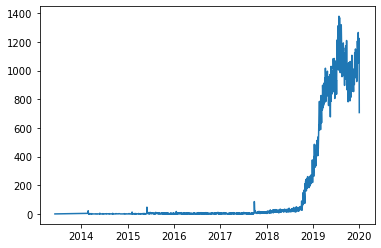

In [19]:
df['timestamp'].dt.date.value_counts().plot()

### Step 2: Scraping with PRAW

Now we'll create a list of post ids from the dataframe we created in step 1.

In [20]:
use_posts = df['id'].tolist()

In [21]:
use_posts

We'll make sure we're requesting a read-only Reddit instance:

In [22]:
reddit.read_only = True

In [23]:
print(len(use_posts))

354953


In [ ]:
f = open('subreddit_posts_out.csv',"w") 
writer = csv.writer(f, quoting=csv.QUOTE_ALL)
header = ["id","timestamp","title","body","edited","verdict","score","num_comments"]
writer.writerow(header)
counter = 0
for idx in use_posts:
    post = reddit.submission(idx)

    score = post.score
    
    if score >= 3:
        title = post.title
        body = post.selftext
        edited = str(post.edited)
        num_comments = post.num_comments
        timestamp = post.created_utc
        verdict = post.link_flair_text 
        if not verdict:
            verdict =  "NA" 
            
        line_stuff = [idx,timestamp,title,body,edited,verdict,score,num_comments]
        writer.writerow(line_stuff)
    else:
        line_stuff = [idx,"NA","NA","NA","NA","NA",score,"NA"]
        writer.writerow(line_stuff)

    if counter % 1000 == 0:
        print(counter)
    counter += 1

f.close()

0
1000


### Step 3: Cleaning and Merging

#### Cleaning the Data

We can define a function to clean the data we've collected. We'll start by useing the `lower` method on the `verdict` key:

In [ ]:
df['verdict'] = df['verdict'].str.lower()

Next, we'll use the `replace` method to add some consistency to our verdicts:

In [ ]:
df['verdict'] = df['verdict'].str.replace("a--hole|a-hole","asshole") 

We'll define a `valid_list` so that our dataset only contains submissions that received valid verdicts.  We'll also use `replace` to remove any edits that could potentially spoil the verdict.

In [ ]:
valid_list = ["asshole","not the asshole","everyone sucks","no assholes here"]
df_use = df[df['verdict'].isin(valid_list)]
df_use['body'] = df_use['body'].str.replace("(edit|update).*?(YTA|a-|ass|\\sta\\s)(.*)","",case=False)

We can generate a `gone_list` to get rid of posts that have been removed or deleted:

In [ ]:
gone_list = ["[deleted]","[removed]",""]
df_use = df_use[df_use['body'].isin(gone_list)==False]
print("After removing deleted posts, there are " +  str(len(df_use)) + " posts left.")

Since r/AmItheAsshole has four potential verdicts, we'll convert these into a binary variable.  Here, "asshole" and "everyone sucks here" will both be considered `is_asshole`, while all other verdicts will not.

In [ ]:
df_use["is_asshole"] = [1 if x in ["asshole","everyone sucks"] else 0 for x in df_use["verdict"]]

Altogether, our `clean_scrape` function will look like this: 

In [ ]:
def clean_scrape(df):

    df['verdict'] = df['verdict'].str.lower()

    df['verdict'] = df['verdict'].str.replace("a--hole|a-hole","asshole") 

    valid_list = ["asshole","not the asshole","everyone sucks","no assholes here"]
    
    df_use = df[df['verdict'].isin(valid_list)]
    
    df_use['body'] = df_use['body'].str.replace("(edit|update).*?(YTA|a-|ass|\\sta\\s)(.*)","",case=False)

    gone_list = ["[deleted]","[removed]",""]
    
    df_use = df_use[df_use['body'].isin(gone_list)==False]
    
    print("After removing deleted posts, there are " +  str(len(df_use)) + " posts left.")
    
    df_use["is_asshole"] = [1 if x in ["asshole","everyone sucks"] else 0 for x in df_use["verdict"]]

    return(df_use)

#### Merging the Data

We can also use the `concat` method from pandas to merge our old and new datasets.  We'll `drop_duplicates` from the concatenated dataset as well. 

In [ ]:
def merge_scrape(old, new):
    # old and new are pandas dataframes. should have the same columns
    old = pd.concat([old,new])
    old = old.drop_duplicates()
    return(old)

raw = pd.read_csv("aita_raw.csv")
grand = clean_scrape(raw)

print("There are now " +  str(len(grand)) + " cleaned posts.")

grand.to_csv("aita_clean.csv",index=False)

Finally, we'll use our `clean_scrape` function on the newly concatenated datasets:

In [ ]:
raw = pd.read_csv("aita_raw.csv")
grand = clean_scrape(raw)

print("There are now " +  str(len(grand)) + " cleaned posts.")
